In [1]:
!pip3 install mnist
!pip3 install minisom

# imports
import matplotlib.pyplot as plt
import numpy as np
import mnist
import scipy.misc
import math

from sklearn import datasets,metrics
from sklearn.datasets import fetch_20newsgroups, fetch_rcv1
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA
from sklearn.manifold import TSNE
import umap
from minisom import MiniSom


from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, SpectralClustering

from sklearn.metrics.pairwise import euclidean_distances

from joblib import Parallel, delayed
from tqdm import tqdm

!pip install ipython-autotime
%load_ext autotime


/home/adalmia1/anaconda3/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


time: 736 µs (started: 2021-01-30 07:20:07 -05:00)


In [2]:
# Load Digits dataset
digits = datasets.load_digits()
digits_n_samples = len(digits.images)
data = digits.images.reshape((digits_n_samples, -1))
digits_X_train, digits_X_test, digits_y_train, digits_y_test = train_test_split(data, digits.target, test_size=0.3, shuffle=True)


# Load full MNIST dataset
MNIST_X_train = mnist.train_images()
MNIST_X_train = MNIST_X_train.reshape((len(MNIST_X_train), -1)) 
MNIST_y_train = mnist.train_labels()

MNIST_X_test = mnist.test_images()
MNIST_X_test = MNIST_X_test.reshape((len(MNIST_X_test), -1)) 
MNIST_y_test = mnist.test_labels()


#print(np.median(euclidean_distances(MNIST_X_train)))
#print(np.median(euclidean_distances(MNIST_X_test)))



time: 636 ms (started: 2021-01-30 07:20:07 -05:00)


In [3]:
# k-Means clustering
def kmeans(X_train, X_test, y_train, y_test, n_clusters):
  kmeans = KMeans(n_clusters=n_clusters, random_state=2)
  y_pred_train = kmeans.fit_predict(X_train)
  train_centers = kmeans.cluster_centers_

  y_pred_test = kmeans.fit_predict(X_test)
  test_centers = kmeans.cluster_centers_

  return y_pred_train, y_pred_test, train_centers, test_centers
  

time: 678 µs (started: 2021-01-30 07:20:08 -05:00)


In [4]:
# Spectral clustering 
def spectral(X_train, X_test, y_train, y_test, n_clusters):
  med = np.median(euclidean_distances(X_train))
  spectral = SpectralClustering(n_clusters=n_clusters, gamma=2*(1/med)**2, random_state=0)
  y_pred_train = spectral.fit_predict(X_train)
  y_pred_test = spectral.fit_predict(X_test)

  return y_pred_train, y_pred_test


time: 981 µs (started: 2021-01-30 07:20:08 -05:00)


In [5]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

# Evaluation function
def evaluate(X, y, y_pred):
    print("Accurary Score: %0.3f" % purity_score(y, y_pred))
    print("Adjusted Mutual Information Score: %0.3f" % metrics.adjusted_mutual_info_score(y, y_pred))
    print("Adjusted Rand Index Score: %0.3f" % metrics.adjusted_rand_score(y, y_pred))
    print("Normalized Mutual Information Score: %0.3f" % metrics.normalized_mutual_info_score(y, y_pred))

    print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, y_pred))
    print("Completeness: %0.3f" % metrics.completeness_score(y, y_pred))
    print("V-measure: %0.3f" % metrics.v_measure_score(y, y_pred))
    #print(np.unique(y_pred))
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, y_pred, sample_size=1000))
    print()



time: 1.03 ms (started: 2021-01-30 07:20:08 -05:00)


In [6]:
# dimension reduction


def pca_reduce(X_train, X_test, dim):
  pca = None
  if scipy.sparse.issparse(X_train):
    pca = TruncatedSVD(n_components=dim)
  else:
    pca = PCA(n_components=dim)
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.fit_transform(X_test)

  return X_train_pca, X_test_pca


def tsne_reduce(X_train, X_test, dim):
  tsne = TSNE(n_components= dim)
  X_train_tsne = tsne.fit_transform(X_train)
  X_test_tsne = tsne.fit_transform(X_test)

  return X_train_tsne, X_test_tsne

def umap_reduce(X_train, X_test, dim):
  umapr = umap.UMAP(n_components=dim,  n_epochs = 800, n_jobs=1)
  X_train_umap = umapr.fit_transform(X_train)
  X_test_umap = umapr.fit_transform(X_test)
  return X_train_umap, X_test_umap


def kernel_pca_reduce(X_train, X_test, dim):
  
  #kernal_pca = KernelPCA(n_components=dim, kernel='rbf', gamma=2*(1/2610)**2, n_jobs=6)
  print("here1")
  X_train_kpca = stepwise_kpca(X_train, 2*(1/2610)**2, dim)
  X_test_kpca = stepwise_kpca(X_test, 2*(1/2610)**2, dim) #kernal_pca.fit_transform(X_test)

  return X_train_kpca, X_test_kpca

def som_reduce(X_train, X_test, dim):

  grid_size_train = math.ceil(np.sqrt(len(X_train))) 
  som = MiniSom(grid_size_train, grid_size_train, X_train.shape[1], sigma=4, learning_rate=0.5, neighborhood_function='triangle')
  som.pca_weights_init(X_train)
  som.train(X_train, 5000, random_order=True, verbose=False)
  X_train_som = np.array(Parallel(n_jobs=1)(delayed(som.winner)(x) for x in tqdm(X_train))) 
  #X_train_som = np.array([som.winner(x) for x in X_train])


  grid_size_test = math.ceil(np.sqrt(len(X_test)))
  som = MiniSom(grid_size_test, grid_size_test, X_train.shape[1], sigma=4, learning_rate=0.5, neighborhood_function='triangle')
  som.pca_weights_init(X_test)
  som.train(X_test, 5000, random_order=True, verbose=False)
  X_test_som = np.array(Parallel(n_jobs=1)(delayed(som.winner)(x) for x in tqdm(X_test))) 



  return X_train_som, X_test_som








def dimension_reduce(dimensions, X_train, X_test, y_train, y_test, reduce, n_clusters):
  y_pred_train, y_pred_test, _, _ = kmeans(X_train, X_test, y_train, y_test, n_clusters)
  print("Original KMeans")
  evaluate(X_train,y_train,y_pred_train) 

  y_pred_train, y_pred_test = spectral(X_train, X_test, y_train, y_test, n_clusters)
  print("Original Spectral")
  evaluate(X_train,y_train,y_pred_train) 
  
  
  for dim in dimensions:
    #PCA reduction
    X_train_pca, X_test_pca = reduce(X_train, X_test, dim)

    y_pred_train, y_pred_test, _, _ = kmeans(X_train_pca, X_test_pca, y_train, y_test, n_clusters)
    print("KMeans dimension reduce: " + str(dim))
    evaluate(X_train_pca,y_train,y_pred_train)

    y_pred_train, y_pred_test= spectral(X_train_pca, X_test_pca, y_train, y_test, n_clusters)
    print("Spectral dimension reduce: " + str(dim))
    evaluate(X_train_pca,y_train,y_pred_train)







time: 2.51 ms (started: 2021-01-30 07:20:08 -05:00)


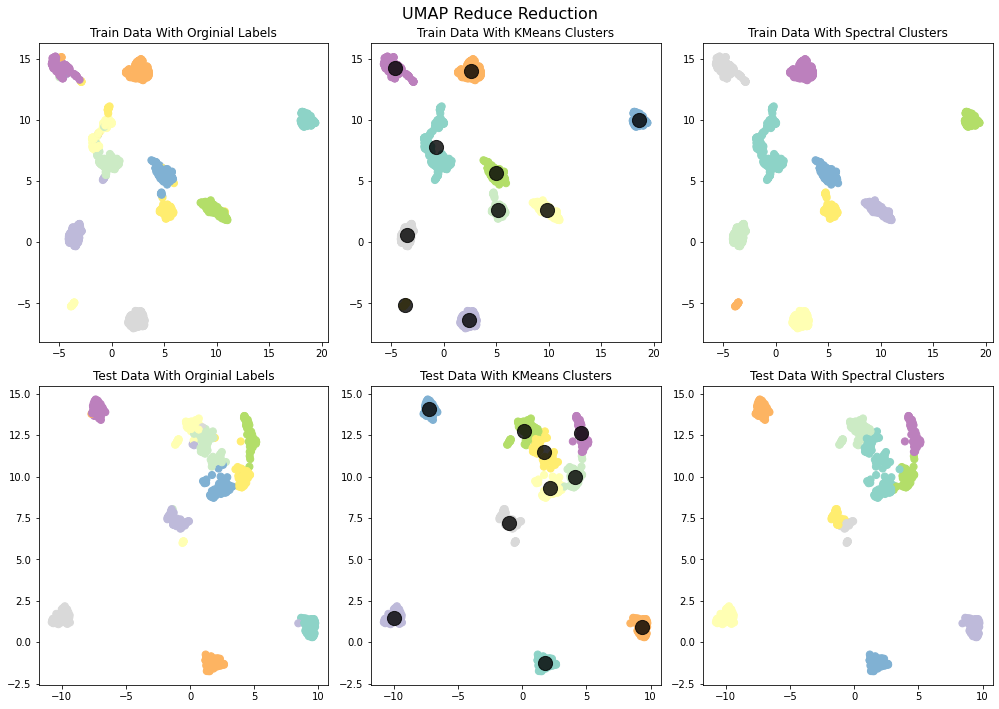

time: 23.4 s (started: 2021-01-30 07:20:08 -05:00)


In [7]:
# Visualization general

def visualize(X_train, X_test, y_train, y_test, reduce, title, n_clusters):

  X_train_r, X_test_r = reduce(X_train, X_test, 2)


  kmy_pred_train, kmy_pred_test, train_centers, test_centers = kmeans(X_train_r, X_test_r, y_train, y_test, n_clusters)
  spy_pred_train, spy_pred_test = spectral(X_train_r, X_test_r, y_train, y_test, n_clusters)

  
  fig=plt.figure(figsize=(14,10))
  # Train orginial labels
  plt.subplot(2, 3, 1)
  plt.gca().set_title('Train Data With Orginial Labels')
  plt.scatter(X_train_r[:, 0], X_train_r[:, 1], c= y_train, s=50, cmap='Set3')

  # Train kmeans labels
  plt.subplot(2, 3, 2)
  plt.gca().set_title('Train Data With KMeans Clusters')
  plt.scatter(X_train_r[:, 0], X_train_r[:, 1], c= kmy_pred_train, s=50, cmap='Set3')
  plt.scatter(train_centers [:, 0], train_centers [:, 1], c='black', s=200, alpha=0.8)

  # Train spectral labels
  plt.subplot(2, 3, 3)
  plt.gca().set_title('Train Data With Spectral Clusters')
  plt.scatter(X_train_r[:, 0], X_train_r[:, 1], c= spy_pred_train, s=50, cmap='Set3')


  # Test orginial labels
  plt.subplot(2, 3, 4)
  plt.gca().set_title('Test Data With Orginial Labels')
  plt.scatter(X_test_r[:, 0], X_test_r[:, 1], c= y_test, s=50, cmap='Set3')

  # Test kmeans labels
  plt.subplot(2, 3, 5)
  plt.gca().set_title('Test Data With KMeans Clusters')
  plt.scatter(X_test_r[:, 0], X_test_r[:, 1], c= kmy_pred_test, s=50, cmap='Set3')
  plt.scatter(test_centers[:, 0], test_centers[:, 1], c='black', s=200, alpha=0.8)

  # Test spectral labels
  plt.subplot(2, 3, 6)
  plt.gca().set_title('Test Data With Spectral Clusters')
  plt.scatter(X_test_r[:, 0], X_test_r[:, 1], c= spy_pred_test, s=50, cmap='Set3')

  fig.suptitle(title + " Reduction", fontsize=16)

  fig.tight_layout()
  fig.subplots_adjust(top=0.93)
  plt.show()

visualize(digits_X_train, digits_X_test, digits_y_train, digits_y_test,  umap_reduce, "UMAP Reduce", 10)



In [8]:
# Digits reduction 
#dimension_reduce([48, 32, 16, 8, 4, 2], digits_X_train, digits_X_test, digits_y_train, digits_y_test, umap_reduce, 10)
#visualize(digits_X_train, digits_X_test, digits_y_train, digits_y_test, som_reduce, "SOM", 10)

#visualize(digits_X_train, digits_X_test, digits_y_train, digits_y_test, tsne_reduce, "TSNE", 10)

time: 348 µs (started: 2021-01-30 07:20:31 -05:00)


In [ ]:
# MNIST reduction 

dimension_reduce([700, 600, 500, 400, 300, 200, 100, 50], MNIST_X_train, MNIST_X_test, MNIST_y_train, MNIST_y_test,umap_reduce, 10)
#dimension_reduce([2], MNIST_X_train, MNIST_X_test, MNIST_y_train, MNIST_y_test,som_reduce, 10)
#visualize(MNIST_X_train, MNIST_X_test, MNIST_y_train, MNIST_y_test, umap_reduce, "UMAP Reduce", 10)
#visualize(MNIST_X_train, MNIST_X_test, MNIST_y_train, MNIST_y_test, som_reduce, "SOM Reduce", 10)
#dimension_reduce([200, 100, 50], MNIST_X_train, MNIST_X_test, MNIST_y_train, MNIST_y_test,umap_reduce, 10)


Original KMeans
Accurary Score: 0.583
Adjusted Mutual Information Score: 0.498
Adjusted Rand Index Score: 0.363
Normalized Mutual Information Score: 0.498
Homogeneity: 0.494
Completeness: 0.501
V-measure: 0.498
Silhouette Coefficient: 0.055

Original Spectral
Accurary Score: 0.586
Adjusted Mutual Information Score: 0.483
Adjusted Rand Index Score: 0.338
Normalized Mutual Information Score: 0.483
Homogeneity: 0.471
Completeness: 0.495
V-measure: 0.483
Silhouette Coefficient: 0.045

KMeans dimension reduce: 700
Accurary Score: 0.862
Adjusted Mutual Information Score: 0.844
Adjusted Rand Index Score: 0.767
Normalized Mutual Information Score: 0.844
Homogeneity: 0.834
Completeness: 0.854
V-measure: 0.844
Silhouette Coefficient: 0.616

Spectral dimension reduce: 700
Accurary Score: 0.854
Adjusted Mutual Information Score: 0.831
Adjusted Rand Index Score: 0.744
Normalized Mutual Information Score: 0.831
Homogeneity: 0.822
Completeness: 0.841
V-measure: 0.831
Silhouette Coefficient: 0.606

KM